# Verifying the dataset samples

This notebook will use the KuHar view (balanced_motionsense_equivalent_view) and will:

1. Apply DFT over dataset windows
2. ...
.
.
.
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import KuHarResampledView20HZ
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-07 20:12:13.592874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 20:12:13.592894: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load KuHar, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = KuHarResampledView20HZ("../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", download=False)
train_val, test = loader.load(concat_train_validation=True, label="standard activity code")

# View balanceada a 100Hz para comparar
# loader = KuHarResampledView20HZ("../../data/old-views/KuHar/balanced_view", download=False)
# train_val, test = loader.load(concat_train_validation=True)


In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[ -1.04282825,   7.06961015,   3.45567162, ...,   0.50890319,
         -0.11305444,  -0.38018973],
       [ -2.43790048,  -2.62844861,  -2.16686063, ...,  -0.09413675,
         -0.23829967,   0.3772596 ],
       [ -0.66433712,   0.48346468,   3.09023849, ...,   0.28845053,
          0.11892508,   0.28859494],
       ...,
       [  3.92724394,  19.31137994,   0.4036726 , ...,   0.92610044,
          1.03635366,  -0.09064377],
       [ -7.20889409, -11.73424672,  13.67743163, ...,  -0.13913523,
          0.74242743,   0.76542017],
       [ -1.30519969,   0.77625489,  -2.01040912, ...,   0.53948006,
          1.16119165,  -0.4627136 ]])

In [6]:
train_val[0][0].shape

(360,)

In [7]:
train_val.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,standard activity code
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,9.159,9.160,12.199,12.201,0,300,23,900,1101,4
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,9.167,9.166,12.211,12.208,0,300,43,900,1101,4
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,15.262,15.263,18.298,18.299,0,300,24,1500,1101,4
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,33.572,33.583,36.615,36.626,0,300,41,3300,1101,4
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,0.008,0.007,3.047,3.048,0,300,30,0,1101,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,-16.047706,-10.232285,-1.393564,22.982999,13.706479,7.789294,-4.720361,-15.633462,-8.674399,-11.634360,...,3.000,3.007,6.000,6.008,5,300,8,300,1042,5
3110,1.911780,-6.910686,1.625745,12.975344,12.066726,5.300426,-10.848059,-14.261385,-3.988711,-4.235381,...,5.927,5.927,8.880,8.879,5,300,2,600,1046,5
3111,3.927244,19.311380,0.403673,-14.236972,-10.454149,-4.218160,-4.307016,17.655546,12.570647,7.031853,...,2.966,2.966,5.920,5.919,5,300,5,300,1046,5
3112,-7.208894,-11.734247,13.677432,21.571222,3.191808,2.215446,-12.397302,-13.905091,-8.743007,11.580156,...,3.003,3.001,5.993,5.991,5,300,6,300,1042,5


In [8]:
train_val.data.describe()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,standard activity code
count,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,...,3114.000000,3114.00000,3114.000000,3114.000000,3114.000000,3114.0,3114.000000,3114.000000,3114.000000,3114.000000
mean,0.350922,0.204873,0.093874,0.082123,0.022674,-0.018123,0.032282,0.172814,0.206576,0.182001,...,21.555240,21.54684,24.498087,24.495775,2.500000,300.0,7.924855,2119.845857,1056.934811,2.500000
std,4.202541,4.743625,4.613882,4.973279,5.186953,5.324605,5.003875,4.869458,4.817284,4.802185,...,19.078489,19.07873,19.062119,19.058105,1.708099,0.0,12.141743,1894.395807,34.215112,1.708099
min,-27.403144,-35.199579,-28.376225,-31.660523,-35.777880,-41.969138,-41.912365,-32.010055,-31.788671,-32.397733,...,0.000000,0.00000,2.331000,2.331000,0.000000,300.0,1.000000,0.000000,1001.000000,0.000000
25%,-0.776858,-0.959588,-1.011894,-1.099345,-0.966302,-0.995343,-1.069375,-1.033333,-0.980337,-1.029696,...,6.003250,6.00350,8.994000,8.995000,1.000000,300.0,1.000000,600.000000,1031.000000,1.000000
50%,0.004507,0.004172,0.003411,0.002408,0.003484,0.002764,0.003694,0.001765,0.003507,0.003085,...,16.572000,16.31600,18.997000,18.989500,2.500000,300.0,3.000000,1500.000000,1044.000000,2.500000
75%,0.979557,0.938036,0.829537,0.865201,0.922267,0.943869,0.926196,1.033290,1.166325,0.990039,...,33.572000,33.57275,36.615000,36.614750,4.000000,300.0,8.000000,3300.000000,1101.000000,4.000000
max,41.923600,42.435657,40.368224,34.051130,33.993680,41.844386,39.706290,32.656278,40.705483,32.889180,...,92.315000,92.02400,95.316000,95.014000,5.000000,300.0,51.000000,10200.000000,1101.000000,5.000000


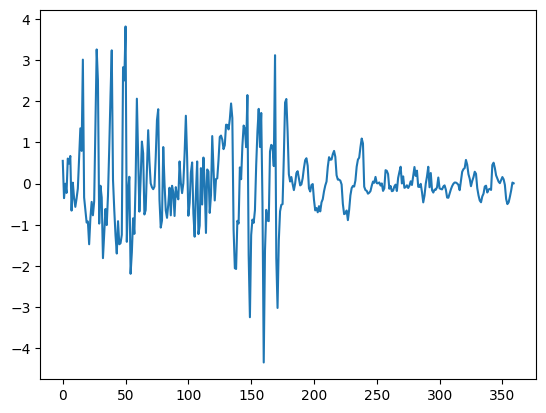

In [9]:
plt.plot(train_val[2000][0])

In [10]:
# Create the objects
#scaler_transform = WindowedTransform(
#    transform=train_scaler, fit_on=None, transform_on="all")

fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="scaled."
)

In [11]:
# Transform it and generate a new dataset!
train_val_fft = transformer(train_val)
test_fft = transformer(test)

In [12]:
# Checking the whole data...
train_val_fft[:][0]

array([[ 5.02447148,  1.61251322,  6.76232259, ...,  0.61856338,
         1.44669533,  0.76661466],
       [ 3.57299732, 10.83009996, 11.81552738, ...,  0.33707892,
         0.57328104,  1.73237447],
       [18.92428589, 22.85409918, 26.51434407, ...,  1.28323215,
         0.74769824,  1.31400771],
       ...,
       [37.2112309 , 19.57891073, 22.52651437, ...,  1.15467725,
         1.07398967,  3.41019869],
       [58.00138092, 13.80286188, 11.50619146, ...,  1.93344645,
         6.26234023,  2.55844602],
       [22.52434513, 15.52963032,  4.92321122, ...,  5.31483603,
         3.63845394,  1.15570768]])

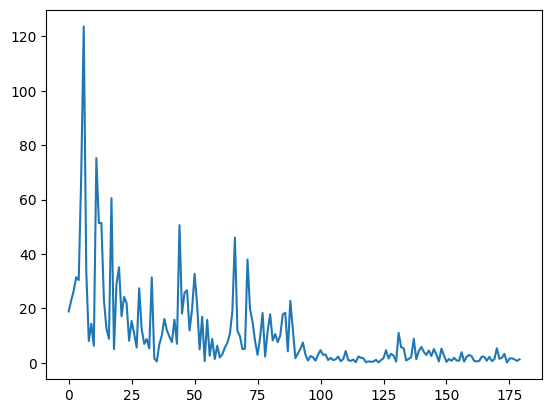

In [13]:
plt.plot(train_val_fft[2][0])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [14]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    normalize='true'
)

### RandomForest (Domínio do Tempo)

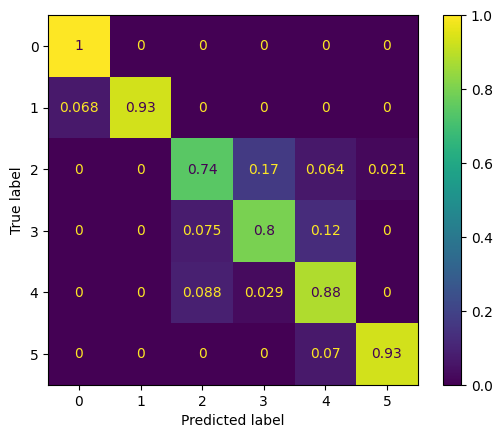

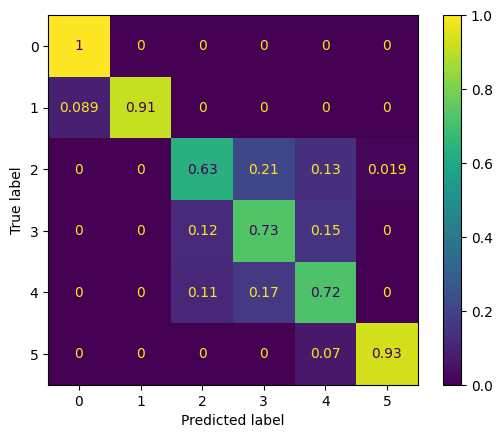

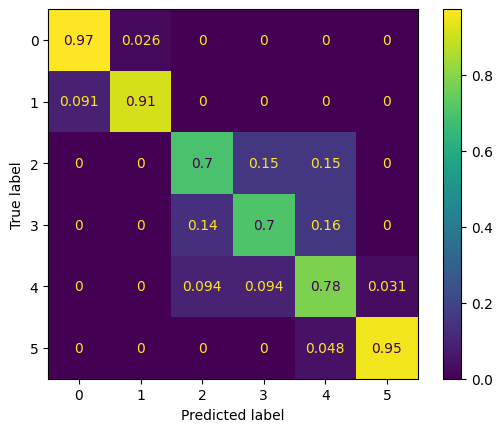

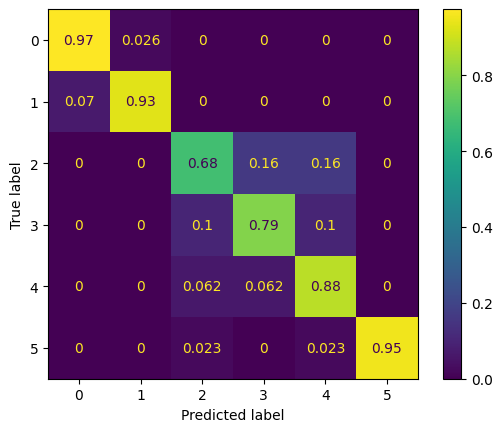

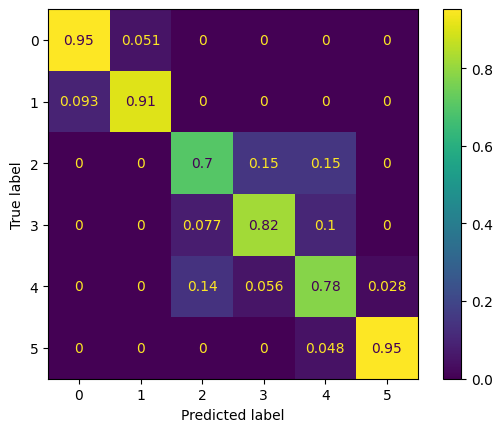

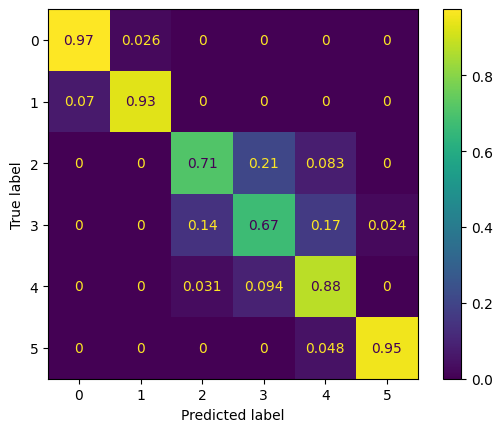

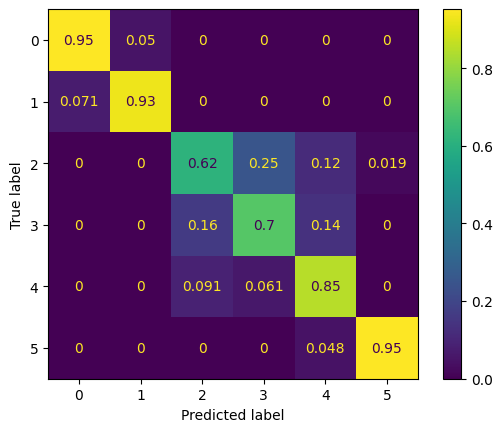

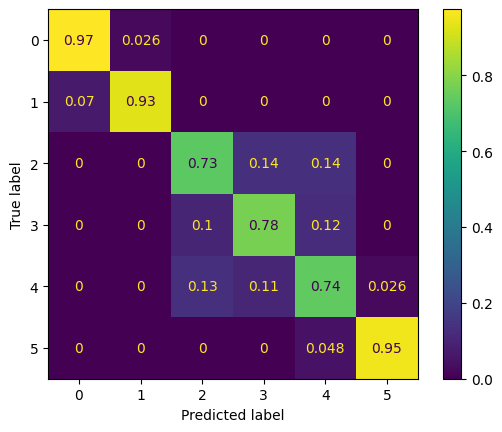

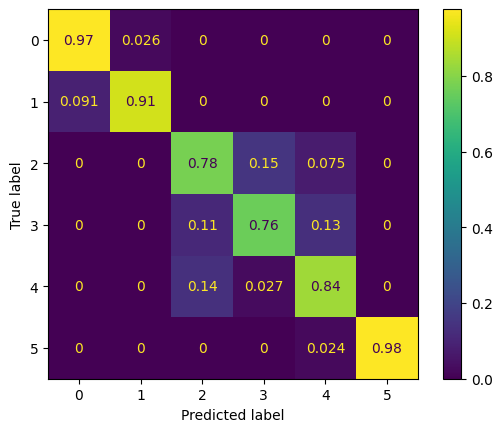

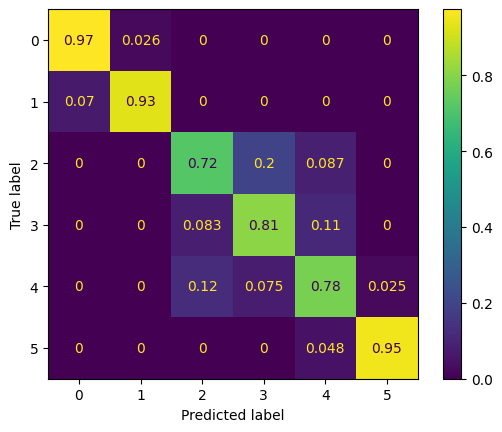

Mean accuracy (10 runs): 0.8488. Mean f1-score: 0.8494
Standard deviation accuracy (10 runs): 0.0183. Standard deviation f1-score: 0.0181


In [15]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val, [test])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### RandomForest (Domínio da Frequência)

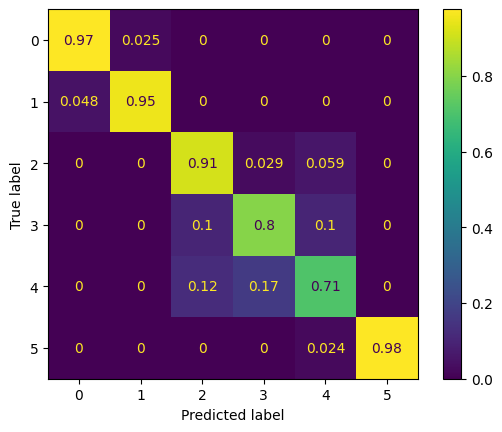

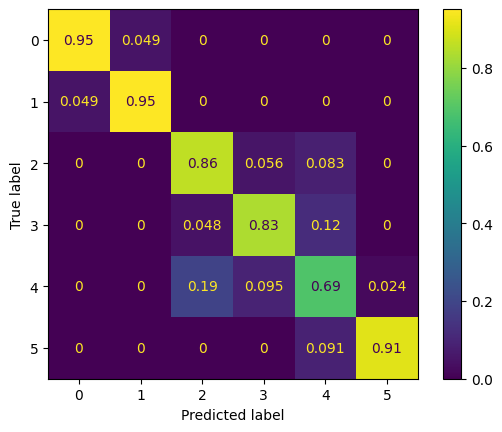

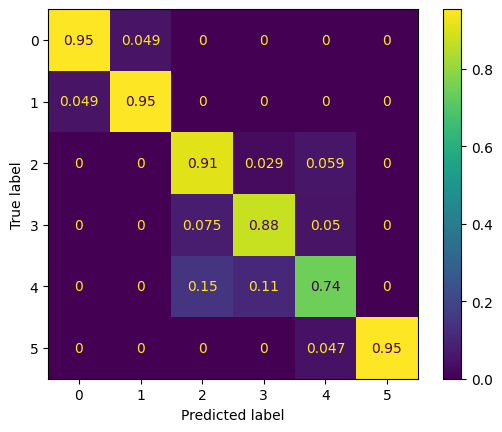

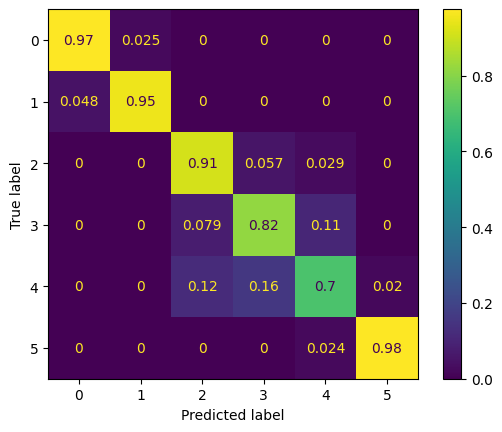

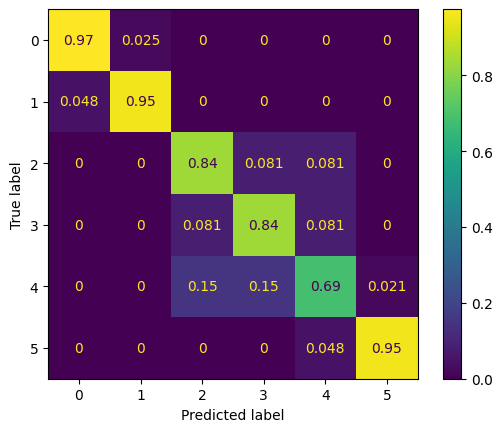

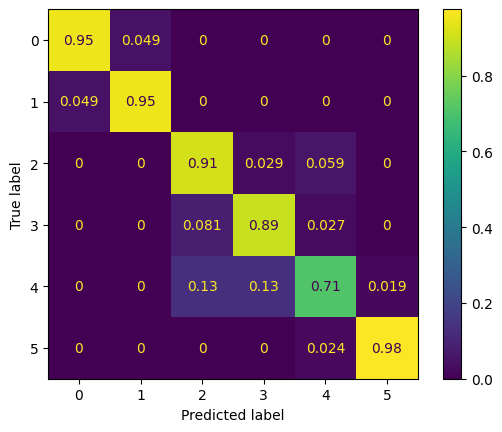

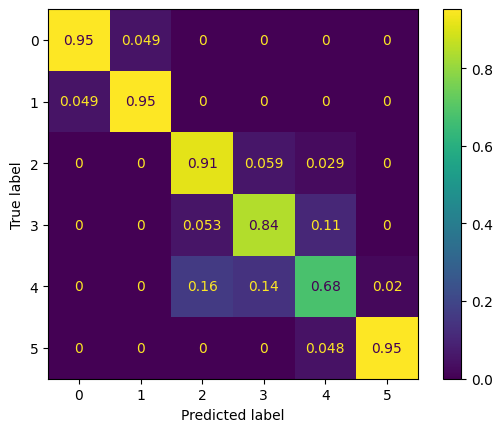

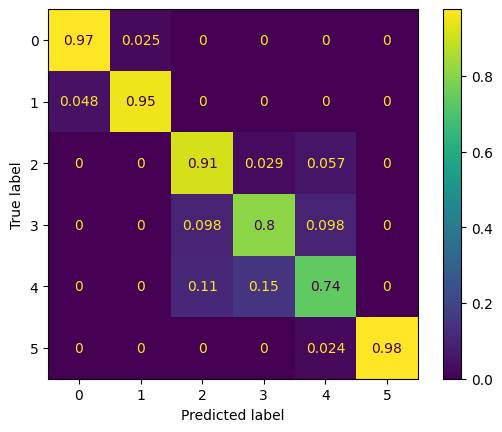

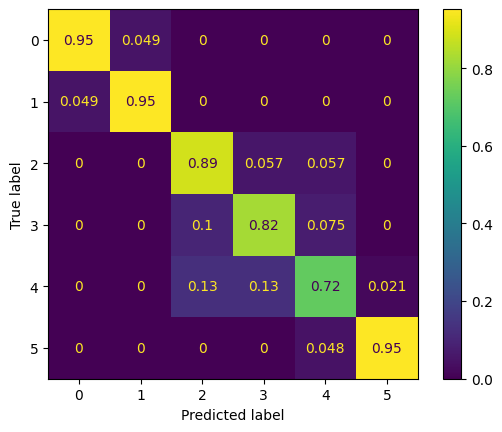

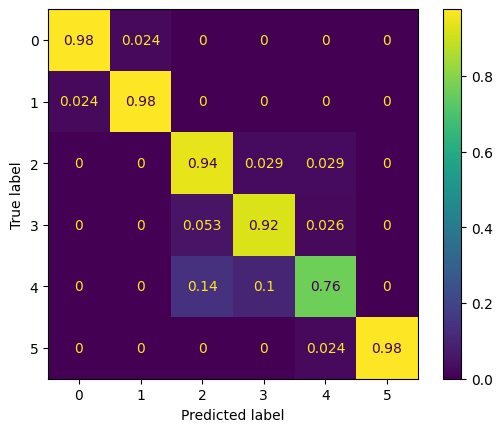

Mean accuracy (10 runs): 0.8846. Mean f1-score: 0.8842
Standard deviation accuracy (10 runs): 0.0143. Standard deviation f1-score: 0.0143


In [16]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### SVM

In [17]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=SVC,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# std_acc = np.std(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# std_f1 = np.std(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
# print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### KNN

In [18]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=KNeighborsClassifier,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# std_acc = np.std(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# std_f1 = np.std(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (1 run): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
# print(f"Standard deviation accuracy (1 run): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Plot UMAP and T-SNE

In [19]:
def plot(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [20]:
labels = {0: "Sit", 1: "Stand", 2: "Walk", 3: "Stair up", 4: "Stair down", 5: "Run"}
print(labels)

{0: 'Sit', 1: 'Stand', 2: 'Walk', 3: 'Stair up', 4: 'Stair down', 5: 'Run'}


### UMAP (Domínio do Tempo)

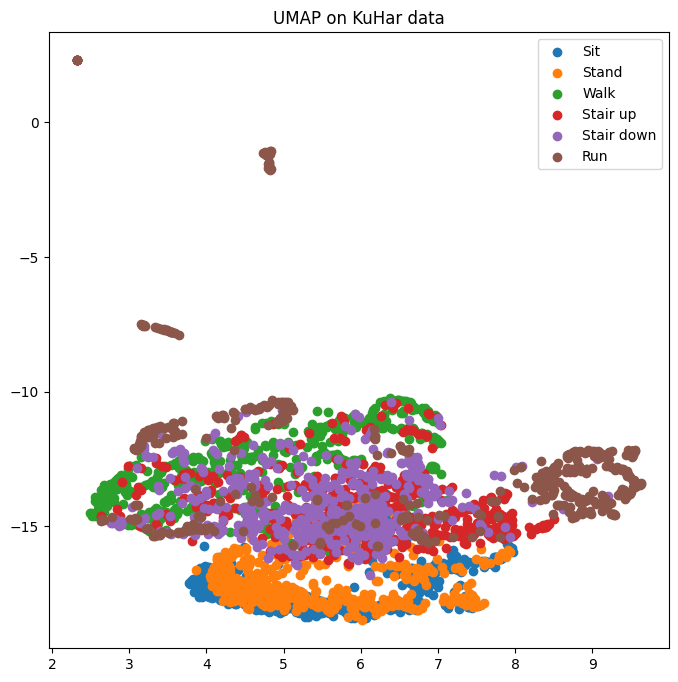

In [21]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="UMAP on KuHar data", labels = labels)

### T-SNE (Domínio do Tempo)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


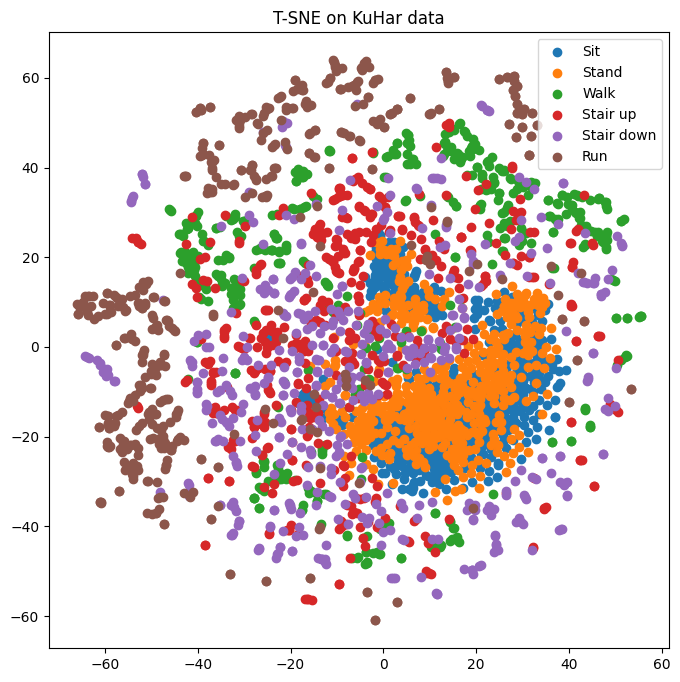

In [22]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="T-SNE on KuHar data", labels=labels)

### UMAP (Domínio da Frequência)

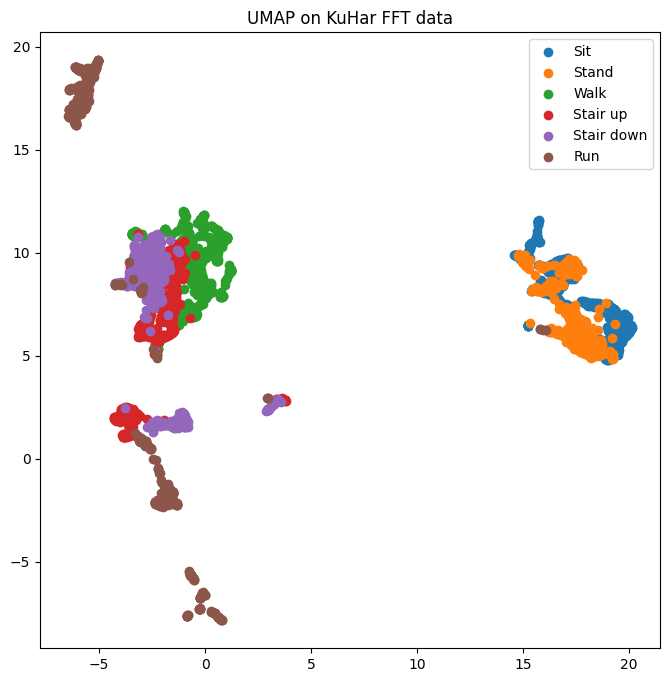

In [23]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="UMAP on KuHar FFT data", labels = labels)

### T-SNE (Domínio da Frequência)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


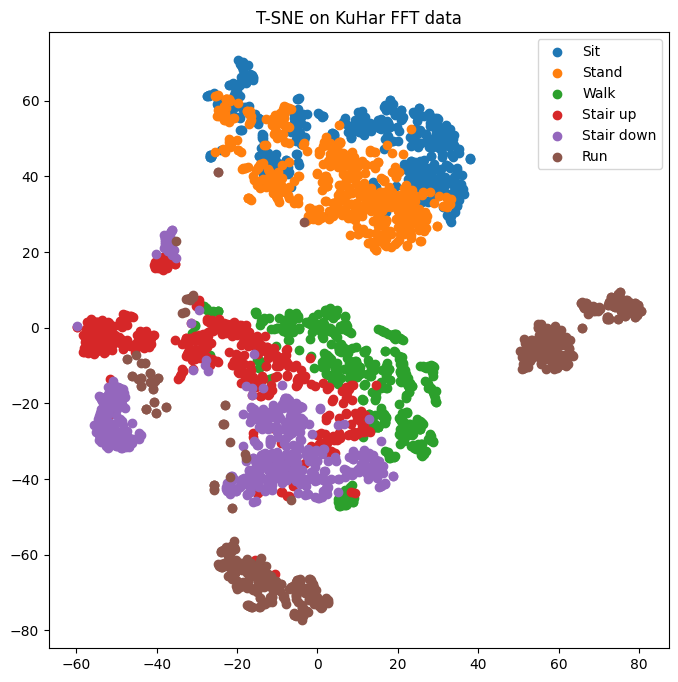

In [24]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="T-SNE on KuHar FFT data", labels=labels)